Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

2023-07-22 23:02:39.161817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


597/600 [============================>.] - ETA: 0s - loss: 0.2919

2023-07-22 23:02:46.167315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 8s 12ms/step - loss: 0.2918 - val_loss: 0.2636
Epoch 2/5
600/600 [==============================] - 7s 11ms/step - loss: 0.2598 - val_loss: 0.2593
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 0.2567 - val_loss: 0.2578
Epoch 4/5
600/600 [==============================] - 7s 11ms/step - loss: 0.2547 - val_loss: 0.2549
Epoch 5/5
  1/157 [..............................] - ETA: 13s

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-07-22 23:03:14.784545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


106/157 [===================>..........] - ETA: 0s

2023-07-22 23:03:15.700877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 0s 2ms/step


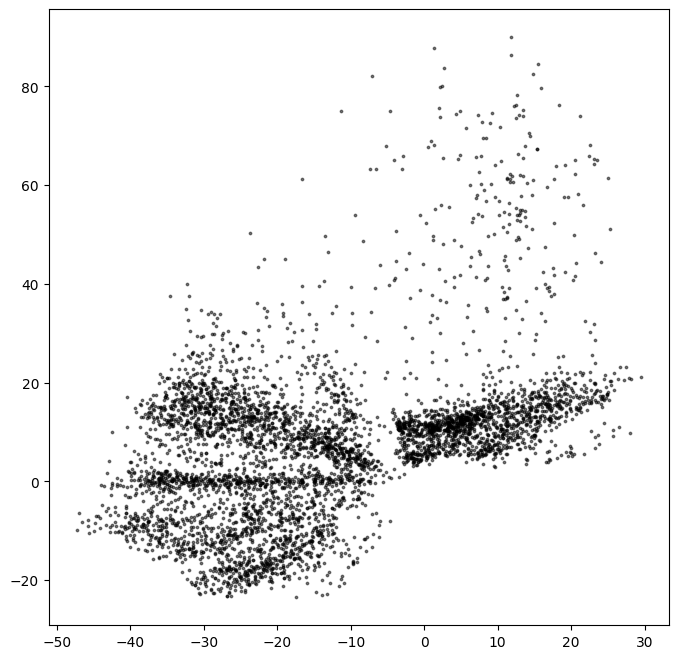

In [5]:
from json import decoder
import numpy as np
from keras import datasets, utils, layers, models, optimizers
import keras
import matplotlib.pyplot as plt
import os

LOAD_FROM_FILE = False
EMBEDDING_DIM = 2

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype('float32') / 255
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), 'constant')
    imgs = np.expand_dims(imgs, axis=-1) # this is to add a channel dimension
    return imgs

# tensorflow.config.set_visible_devices([], 'GPU')


x_train = preprocess(x_train)
x_test = preprocess(x_test)

if not LOAD_FROM_FILE:
    # Encoder
    input_layer = layers.Input(shape=(32, 32, 1))

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(input_layer)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    # x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    shape_before_flattening = keras.backend.int_shape(x)[1:]

    x = layers.Flatten()(x)
    # x = layers.Dropout(rate=0.5)(x)

    output_layer = layers.Dense(units=EMBEDDING_DIM)(x)
    encoder = models.Model(inputs=input_layer, outputs=output_layer)

    encoder.summary()

    # Decoder
    input_layer = layers.Input(shape=(EMBEDDING_DIM,))
    x = layers.Dense(units=np.prod(shape_before_flattening), activation='relu')(input_layer)
    x = layers.Reshape(target_shape=shape_before_flattening)(x)

    # x = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    decoder_output = layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)

    decoder = models.Model(inputs=input_layer, outputs=decoder_output)

    # Autoencoder
    autoencoder = models.Model(inputs=encoder.input, outputs=decoder(encoder.output))

    autoencoder.summary()

    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

    autoencoder.fit(x_train, x_train, epochs=5, batch_size=100, validation_data=(x_test, x_test))

    # Saving the model
    encoder.save('encoder.h5')
    decoder.save('decoder.h5')
    autoencoder.save('autoencoder.h5')
else:
    encoder = models.load_model('encoder.h5')
    decoder = models.load_model('decoder.h5')
    autoencoder = models.load_model('autoencoder.h5')

# Plotting
example_imgs = x_test[:5000]
prediction = autoencoder.predict(example_imgs)

# fig = plt.figure(figsize=(40, 10))
# for i in range(10):
#     plt.subplot(1, 10, i + 1)
#     plt.imshow(example_imgs[i, :, :, 0], cmap='gray')
#     plt.axis('off')

# fig = plt.figure(figsize=(40, 10))
# for i in range(10):
#     plt.subplot(1, 10,  i + 1)
#     plt.imshow(prediction[i, :, :, 0], cmap='gray')
#     plt.axis('off')
    
# Visualizing the latent space
embeddings = encoder.predict(example_imgs)
plt.figure(figsize=(8, 8))
# plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_test[:5000], cmap='tab10', alpha=0.5, s=3)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

# Generating new images
# mins, maxs = embeddings.min(axis=0), embeddings.max(axis=0)
# sample = np.random.rand(18, EMBEDDING_DIM) * (maxs - mins) + mins
# reconstructions = decoder.predict(sample)

# fig = plt.figure(figsize=(40, 10))
# for i in range(10):
#     plt.subplot(1, 10,  i + 1)
#     plt.imshow(reconstructions[i, :, :, 0], cmap='gray')
#     plt.axis('off')
